# Feature Selection

Simply put, feature selection is the process for reducing the number of predictors used to train a machine learning model. While in theory it may seem intuitive to provide your model with all the information you have, and allow the model to determine the importance of your data iteratively through the learning process. In practice, we find the quantity of data required for a model to generalise over grows exponentially as the number of features or dimensions increases, this is know colloquially as the curse of dimensionality.  

It’s often the case that our training dataset contains features that are more important than others, and some irrelevant entirely. Especially when using packages like TsFresh. In general, feature selection can be achieved either by filtering, where prior to feeding data through a model features are removed using some kind of statistical modeling. Or through wrapping where model performance is evaluated through sampling of the feature space

## ANOVA-F

Starting with an example from the sklearn library, the iris dataset. Where, we look to classify 3 types of irises’ (Setosa, Versicolour, and Virginica) using the features Sepal Length, Sepal Width, Petal Length and Petal Width.

In [1]:
from sklearn.datasets import load_iris
data = load_iris()

Our first method for filtering features is known as the Analysis of variance (ANOVA), here we look at the variation/separation of the mean of feature distributions across classification classes using statistical F-tests.

To start, an F-statistic is the ratio of two variances, where the variance is a measure of the dispersion of data from the mean.

For the ANOVA-F test we compare the "distance between class variance" to the class variance.

Intuitively we can see below how analysing the separation of class means, and the variance of classes is useful for feature selection.

Below we have plotted the value of two features on the x and y axis for two classes coloured blue and orange, the data has then been projected onto each axis to visualise the separation of classes. Here, it is clear that y is a better separator than x because there is less overlap between the distributions of both classes (greater separation of means and less compactness of classes). Specifically, according to the y feature, the classes are far away from each other (i.e. the distance between the means of class distribution is greater). For the y feature the distributions also do not overlap, each class distribution is more compact for y than x, and so less likely to overlap (i.e. the variance of each class distribution is lower). This outlines the two variance we compare in the ANOVA-F test.

distance between classes/compactness of classes

Where the higher the ratio, the better the feature and separating classes.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x, y)

    # now determine nice limits by hand:
    binwidth = 0.25
    xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    lim = (int(xymax/binwidth) + 1) * binwidth
    bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, bins=bins)
    ax_histy.hist(y, bins=bins, orientation='horizontal')

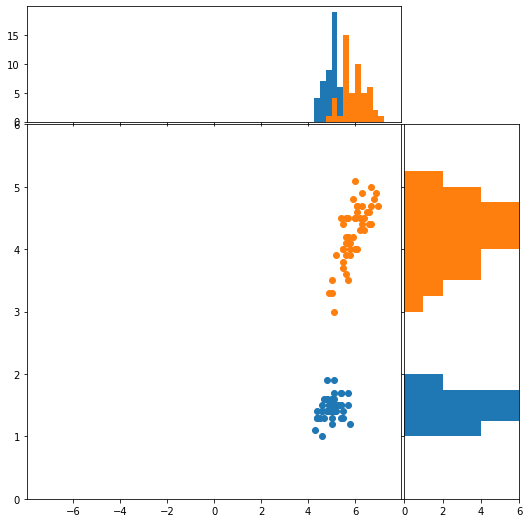

In [4]:

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005


rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(8, 8))

ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)


x1 = data['data'][np.where(data['target']==0)][:,[0]]
y1 = data['data'][np.where(data['target']==0)][:,[2]]
# use the previously defined function
scatter_hist(x1, y1, ax, ax_histx, ax_histy)

x2 = data['data'][np.where(data['target']==1)][:,[0]]
y2 = data['data'][np.where(data['target']==1)][:,[2]]
# use the previously defined function
scatter_hist(x2, y2, ax, ax_histx, ax_histy)

plt.xlim(0,6)
plt.ylim(0,6)

plt.show()

In [5]:
from scipy.stats import f_oneway

def binary_f_score(x1:np.array, x2:np.array) -> float:
    """Return the f score of a feature for a binary classficiation task.
    
    Args:
      - x1: class 1 feature array
      - x2: class 2 feature array
    """
    
    #Ratio numerator, the distance between means of each class, weighted by the population of each class.
    mean = np.mean(np.array([ x1, x2 ])) # mean of all data
    mean_1 = np.mean(x1) #mean of class 1
    mean_2 = np.mean(x2) #mean of class 2
    n_x = x1.shape[0]*(mean_1-mean)**2 + x2.shape[0]*(mean_2-mean)**2 #

    #Class variance, Analogous to sample variance (https://www.onlinemathlearning.com/variance.html) Sum of squares within class divided by sum of total population.
    SSW_1 = np.sum((x1-mean_1)**2)
    SSW_2 = np.sum((x2-mean_1)**2)
    d_x = (SSW_1+SSW_2)/((x1.shape[0]-1)+(x2.shape[0]-1))

    return n_x/d_x



In [6]:
f_1 = binary_f_score(x1,x2)
f_2 = binary_f_score(y1,y2)
print(f"Feature x, F-Score: {f_1}")
print(f"Feature y, F-Score: {f_2}")
print(f"Feature {np.argmax([f_1,f_2])} Wins !")


Feature x, F-Score: 33.96472741727628
Feature y, F-Score: 47.50746721883993
Feature 1 Wins !


## Wrapper OLS 

The wrapper method uses a model dependant metric to evaluate the performance of features. This method is particularly greedy, as we are going to iteratively evaluate the performance of a model and the respective features for the entire feature space, with each run of the model we are going to remove the worst performing feature and re run the model. This continues until the value of our chosen metric for the worst performing feature is below a given threshold. This process is known as Step Back feature selection, the opposite Step Forward can also be done (although i haven’t tested this a whole lot). Due to the greedy nature of this method it is recommended to use this feature selection method following a preliminary reduction of the feature space, such as ANOVA-F or ExtreTrees.

In [229]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
data = load_breast_cancer()

In [230]:
X = pd.DataFrame(data['data'], columns=['feature_{}'.format(i) for i in range(data['data'].shape[1])])
y = data['target']
X

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,14.910,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,25.450,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,23.690,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,18.980,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,25.740,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400


In [235]:

def wrapper_OLS(X, y, feats=None, thresh=10 * 10e-7):
    import statsmodels.api as sm

    X_new = sm.add_constant(X[feats])

    model = sm.OLS(y, X_new).fit()
    model.pvalues

    if feats is None:
        top_wrapper = X.columns.tolist()
    else:
        top_wrapper = feats

    pmax = 1
    
    while len(top_wrapper) > 0:
        p = []

        X_new = X[top_wrapper]
        X_new = sm.add_constant(X_new)

        model = sm.OLS(y, X_new).fit()

        p = pd.Series(model.pvalues.values[1:], index=top_wrapper)

        print('Bottom 5 Features:')
        print(p.sort_values()[-5:])

        pmax = max(p)

        feature_pmax = p.idxmax()

        if pmax > thresh:
            top_wrapper.remove(feature_pmax)
        else:
            break

    return top_wrapper, p


In [236]:
top_n = 5
top_wrapper, p = wrapper_OLS(X, y, feats=X.columns.tolist(), thresh=10 * 10e-7)
top_wrapper = p.nsmallest(top_n).index.values


Bottom 5 Features:
feature_25    0.860902
feature_8     0.890067
feature_4     0.966529
feature_15    0.976145
feature_9     0.995240
dtype: float64
Bottom 5 Features:
feature_11    0.854456
feature_25    0.855102
feature_8     0.890067
feature_4     0.965257
feature_15    0.976352
dtype: float64
Bottom 5 Features:
feature_24    0.705653
feature_25    0.806017
feature_11    0.853746
feature_8     0.889478
feature_4     0.967554
dtype: float64
Bottom 5 Features:
feature_27    0.605879
feature_22    0.678266
feature_25    0.808471
feature_11    0.856529
feature_8     0.883741
dtype: float64
Bottom 5 Features:
feature_12    0.573192
feature_27    0.612051
feature_22    0.680165
feature_25    0.825525
feature_11    0.877632
dtype: float64
Bottom 5 Features:
feature_24    0.548588
feature_12    0.561979
feature_27    0.598448
feature_22    0.685406
feature_25    0.822968
dtype: float64
Bottom 5 Features:
feature_18    0.539737
feature_12    0.544189
feature_24    0.574441
feature_27    0.57

# Extra Trees

An extra trees classifier is an ensemble of aggregated decision tree classifiers into a “forest”. Each tree in the forest is given a random sample of k features, each tree then determines the top performing feature by selecting a random cutpoint for each feature, the separation of classes is then evaluated using a statistical criteria, typically Entropy or Gini. The result is multiple decision trees where a random sub set of features for each tree have been ranked. This is useful for feature selection as the feature importance, and therefore the top performing features are automatically determined during the training process. This process can be run multiple times, where the top n features are determined. The features returned from each run can then be compared, once subsequent runs are found to return no new features then the process is ended. This method is useful for filtering large numbers of features.

In [243]:
from sklearn.ensemble import ExtraTreesClassifier


def extra_trees_classifier(
    X: pd.DataFrame,
    y,
    limit=50,
    n_estimators=100,
    criterion="entropy",
    max_features=3,
    extracted_per_run: int = 10,
    plot=False,
):
    top = []
    for i in range(limit):
        extra_tree_forest = ExtraTreesClassifier(
            n_estimators=n_estimators, criterion=criterion, max_features=max_features
        )

        # Training the model
        extra_tree_forest.fit(X, y)

        # Computing the importance of each feature
        feature_importance = extra_tree_forest.feature_importances_

        # Normalizing the individual importances
        feature_importance_normalized = np.std(
            [tree.feature_importances_ for tree in extra_tree_forest.estimators_],
            axis=0,
        )

        feat_importances = pd.Series(feature_importance_normalized, index=X.columns)

        nlargest = feat_importances.nlargest(extracted_per_run)
        if plot:
            nlargest.plot(kind="barh")
            plt.show()

        top_100 = nlargest.index.values.tolist()

        top = list(top)
        s1 = len(top)

        diff_len = len(set(top_100) - set(top))
        top.extend(top_100)
        top = set(top)

        s2 = len(list(top))

        print(f"Run: {i + 1}, Stored features: {s1}, total features {s2}, new features: {diff_len}")

        if s1 == s2:
            break

    return list(set(top))


In [244]:
extra_trees_classifier(X, y)

Run: 1, Stored features: 0, total features 10, new features: 10
Run: 2, Stored features: 10, total features 11, new features: 1
Run: 3, Stored features: 11, total features 11, new features: 0


['feature_2',
 'feature_26',
 'feature_27',
 'feature_23',
 'feature_6',
 'feature_3',
 'feature_22',
 'feature_13',
 'feature_7',
 'feature_0',
 'feature_20']